## RL and Advanced DL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

![IMG](XO.png)

### Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1.	Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2.	Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.<br>

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [ ]:
import gym
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import copy
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict, deque
from itertools import count

import cProfile
from datetime import datetime

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam, lr_scheduler

from IPython.display import clear_output

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

### Реализация крестиков-ноликов

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        self.gameOver = False
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x + 1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([self.board[i + k, j + k] == cur_p for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([self.board[i + k, j - k] == cur_p for k in range(self.n_win)])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----' * self.n_cols + '-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                else:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----' * self.n_cols + '-')

    def getState(self):
        return self.getHash(), self.getEmptySpaces(), self.curTurn

    def action_from_int(self, action_int):
        return int(action_int / self.n_cols), int(action_int % self.n_cols)

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            self.curTurn = -self.curTurn
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

#### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [4]:
class Player:
    def __init__(self, epsilon=0.1, alpha=0.05, gamma=0.8):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        # Для каждого состояния - разное количество возможных действий
        # Q - словарь, ключ - состояние, значение - словарь действий, в котором ключи - возможные ходы, а значения - вес
        self.Q = defaultdict(dict)

    @staticmethod
    def get_empty_spaces(state, done=False):
        """
        Список координат пустых полей
        """
        empty_spaces = []
        state_array = np.array(list(map(int, state)))
        res = np.where(state_array == 1)
        if len(res[0]) == 0 or done:
            return empty_spaces
        for ind in res[0]:
            pos = env.action_from_int(ind)
            empty_spaces.append(pos)
        return empty_spaces

    def check_Q(self, state, empty_spaces, random_start=False):
        """
        Добавляет state в Q, если его еще нет,
        и проставляет возможным действиям стартовые веса (рандом, если random_start=True, иначе 0)
        """
        if state not in self.Q:
            actions = [tuple(map(int, action)) for action in empty_spaces]  # возможные действия при данном state
            if random_start:
                self.Q[state] = {action: random.random() for action in actions}
            else:
                self.Q[state] = {action: 0 for action in actions}
            
    def get_action(self, state):
        empty_spaces = self.get_empty_spaces(state)
        self.check_Q(state, empty_spaces, random_start=False)
        if random.random() > self.epsilon:
            action = max(self.Q[state].items(), key=lambda x: x[1])[0]
        else:
            action = random.choice(list(self.Q[state].keys()))
        return action

    def update_Q(self, state, action, next_state, reward, done):
        empty_spaces = self.get_empty_spaces(state)
        self.check_Q(state, empty_spaces, random_start=False)
        if next_state is None:
            self.Q[state][action] = reward
        else:
            next_empty_spaces = self.get_empty_spaces(next_state, done)
            if done:
                next_state_value = 0
            else:
                self.check_Q(next_state, next_empty_spaces, random_start=False)
                next_state_value = max(self.Q[next_state].values())
            self.Q[state][action] = (1 - self.alpha) * self.Q[state][action] + self.alpha * (reward + self.gamma * next_state_value)
            
            

Обучать будем двух игроков: одного за крестики, другого за нолики. Учиться они будут друг с другом, а проверять будем каждого на игре с рандомной стратегией.<br><br>
Чтобы обновить Q, нам необходимо знать текущее состояние среды и будущее состояние среды после хода игрока. То есть фиксируем состояние, делаем ход (состояние поменялось, но это еще не то состояние, которое нам нужно), ждем хода соперника, и, после его хода, получаем наше новое состояние для обновления Q.

In [13]:
class Game:
    def __init__(self, env, player_x, player_o):
        self.env = env
        
        self.done = False
        self.current_turn = 1
        
        self.player_x = player_x
        self.state_x = None
        self.action_x = None
        self.prev_state_x = None
        self.prev_action_x = None
        self.reward_x = 0
        
        self.player_o = player_o
        self.state_o = None
        self.action_o = None
        self.prev_state_o = None
        self.prev_action_o = None
        self.reward_o = 0
        
    def reset(self):
        self.env.reset()
        
        self.done = False
        self.current_turn = 1
        
        self.state_x = self.env.getHash()
        self.action_x = self.player_x.get_action(self.state_x)
        self.prev_state_x = None
        self.prev_action_x = None
        self.reward_x = 0
        
        self.state_o = None
        self.action_o = None
        self.prev_state_o = None
        self.prev_action_o = None
        self.reward_o = 0
        
    def set_action(self):
        if self.current_turn == 1:
            self.prev_action_x = self.action_x
            if self.done:
                self.action_x = None
            else:
                self.action_x = self.player_x.get_action(self.state_x)
        else:
            self.prev_action_o = self.action_o
            if self.done:
                self.action_o = None 
            else:
                self.action_o = self.player_o.get_action(self.state_o)

    def set_reward(self, reward):
        self.reward_x = reward
        self.reward_o = -reward
        if reward == -10:
            if self.current_turn == 1:
                self.reward_x = 0
                self.reward_o = -10
            else:
                self.reward_x = -10
                self.reward_o = 0

    def env_step(self):
        if self.current_turn == 1:
            self.prev_state_o = self.state_o  # зафиксировали состояние
            _, reward, self.done, _ = self.env.step(self.action_x)  # сделали ход соперником
            self.current_turn = self.env.curTurn
            self.state_o = self.env.getHash()  # получили новое состояние
            self.set_action()
            self.set_reward(reward)
            if self.prev_state_o is not None and self.prev_action_o is not None:
                self.player_o.update_Q(self.prev_state_o, self.prev_action_o, self.state_o, self.reward_o, self.done)
            if self.done:
                self.player_x.update_Q(self.state_x, self.action_x, None, self.reward_x, self.done)
        else:
            self.prev_state_x = self.state_x  # зафиксировали состояние
            _, reward, self.done, _ = self.env.step(self.action_o)  # сделали ход соперником
            self.current_turn = self.env.curTurn
            self.state_x = self.env.getHash()  # получили новое состояние
            self.set_action()
            self.set_reward(reward)
            if self.prev_action_x is not None:
                self.player_x.update_Q(self.prev_state_x, self.prev_action_x, self.state_x, self.reward_x, self.done)
            if self.done:
                self.player_o.update_Q(self.state_o, self.action_o, None, self.reward_o, self.done)

    def evaluate_policy(self):
        """
        Проверяем стратегии на 1000 итерациях игры с рандомным соперником: отдельно для x и для o
        """
        total_rewards_x = []
        total_rewards_o = []
        for i in range(1000):
            self.reset()
            done = False
            reward = 0
            while not done:
                # сначала крестики
                if self.env.curTurn == 1:
                    state_x = self.env.getHash()
                    action_x = self.player_x.get_action(state_x)
                    _, reward, done, _ = self.env.step(action_x)
                else:
                    action_o = random.choice(self.env.getEmptySpaces())  # рандомный соперник
                    _, reward, done, _ = self.env.step(action_o)
            self.set_reward(reward)
            total_rewards_x.append(self.reward_x)
            self.reset()
            done = False
            while not done:
                # теперь нолики
                if self.env.curTurn == -1:
                    state_o = self.env.getHash()
                    action_o = self.player_o.get_action(state_o)
                    _, reward, done, _ = self.env.step(action_o)
                else:
                    action_x = random.choice(self.env.getEmptySpaces())  # рандомный соперник
                    _, reward, done, _ = self.env.step(action_x)
            self.set_reward(reward)
            total_rewards_o.append(self.reward_o)
        return np.mean(total_rewards_x), np.mean(total_rewards_o)

    def train(self, iterations):
        rewards_x = []
        rewards_o = []
        steps = []
        for i in tqdm(range(iterations)):
            self.reset()
            while not self.done:
                self.env_step()
            # Каждые 1000 итераций выполняем оценку стратегий
            if (i + 1) % 1000 == 0:
                mean_reward_x, mean_reward_o = self.evaluate_policy()
                rewards_x.append(mean_reward_x)
                rewards_o.append(mean_reward_o)
                steps.append(i + 1)
                if (i + 1) % 10000 == 0:
                    print(f'{i + 1}({iterations}): [X: {mean_reward_x} | O: {mean_reward_o}]')
        return steps, rewards_x, rewards_o


Обучим для доски 3х3.

In [6]:
%%time
env = TicTacToe(3, 3, 3)

epsilon = 0.3
player_x = Player(epsilon=epsilon)
player_o = Player(epsilon=epsilon)

iterations = 200000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

10000(200000): [X: 0.738 | O: 0.288]
20000(200000): [X: 0.809 | O: 0.328]
30000(200000): [X: 0.813 | O: 0.424]
40000(200000): [X: 0.827 | O: 0.478]
50000(200000): [X: 0.812 | O: 0.458]
60000(200000): [X: 0.856 | O: 0.518]
70000(200000): [X: 0.802 | O: 0.536]
80000(200000): [X: 0.84 | O: 0.567]
90000(200000): [X: 0.849 | O: 0.547]
100000(200000): [X: 0.878 | O: 0.583]
110000(200000): [X: 0.869 | O: 0.45]
120000(200000): [X: 0.858 | O: 0.52]
130000(200000): [X: 0.872 | O: 0.51]
140000(200000): [X: 0.856 | O: 0.546]
150000(200000): [X: 0.862 | O: 0.554]
160000(200000): [X: 0.848 | O: 0.561]
170000(200000): [X: 0.879 | O: 0.553]
180000(200000): [X: 0.866 | O: 0.56]
190000(200000): [X: 0.866 | O: 0.576]
200000(200000): [X: 0.888 | O: 0.599]
CPU times: user 5min 51s, sys: 716 ms, total: 5min 52s
Wall time: 5min 54s


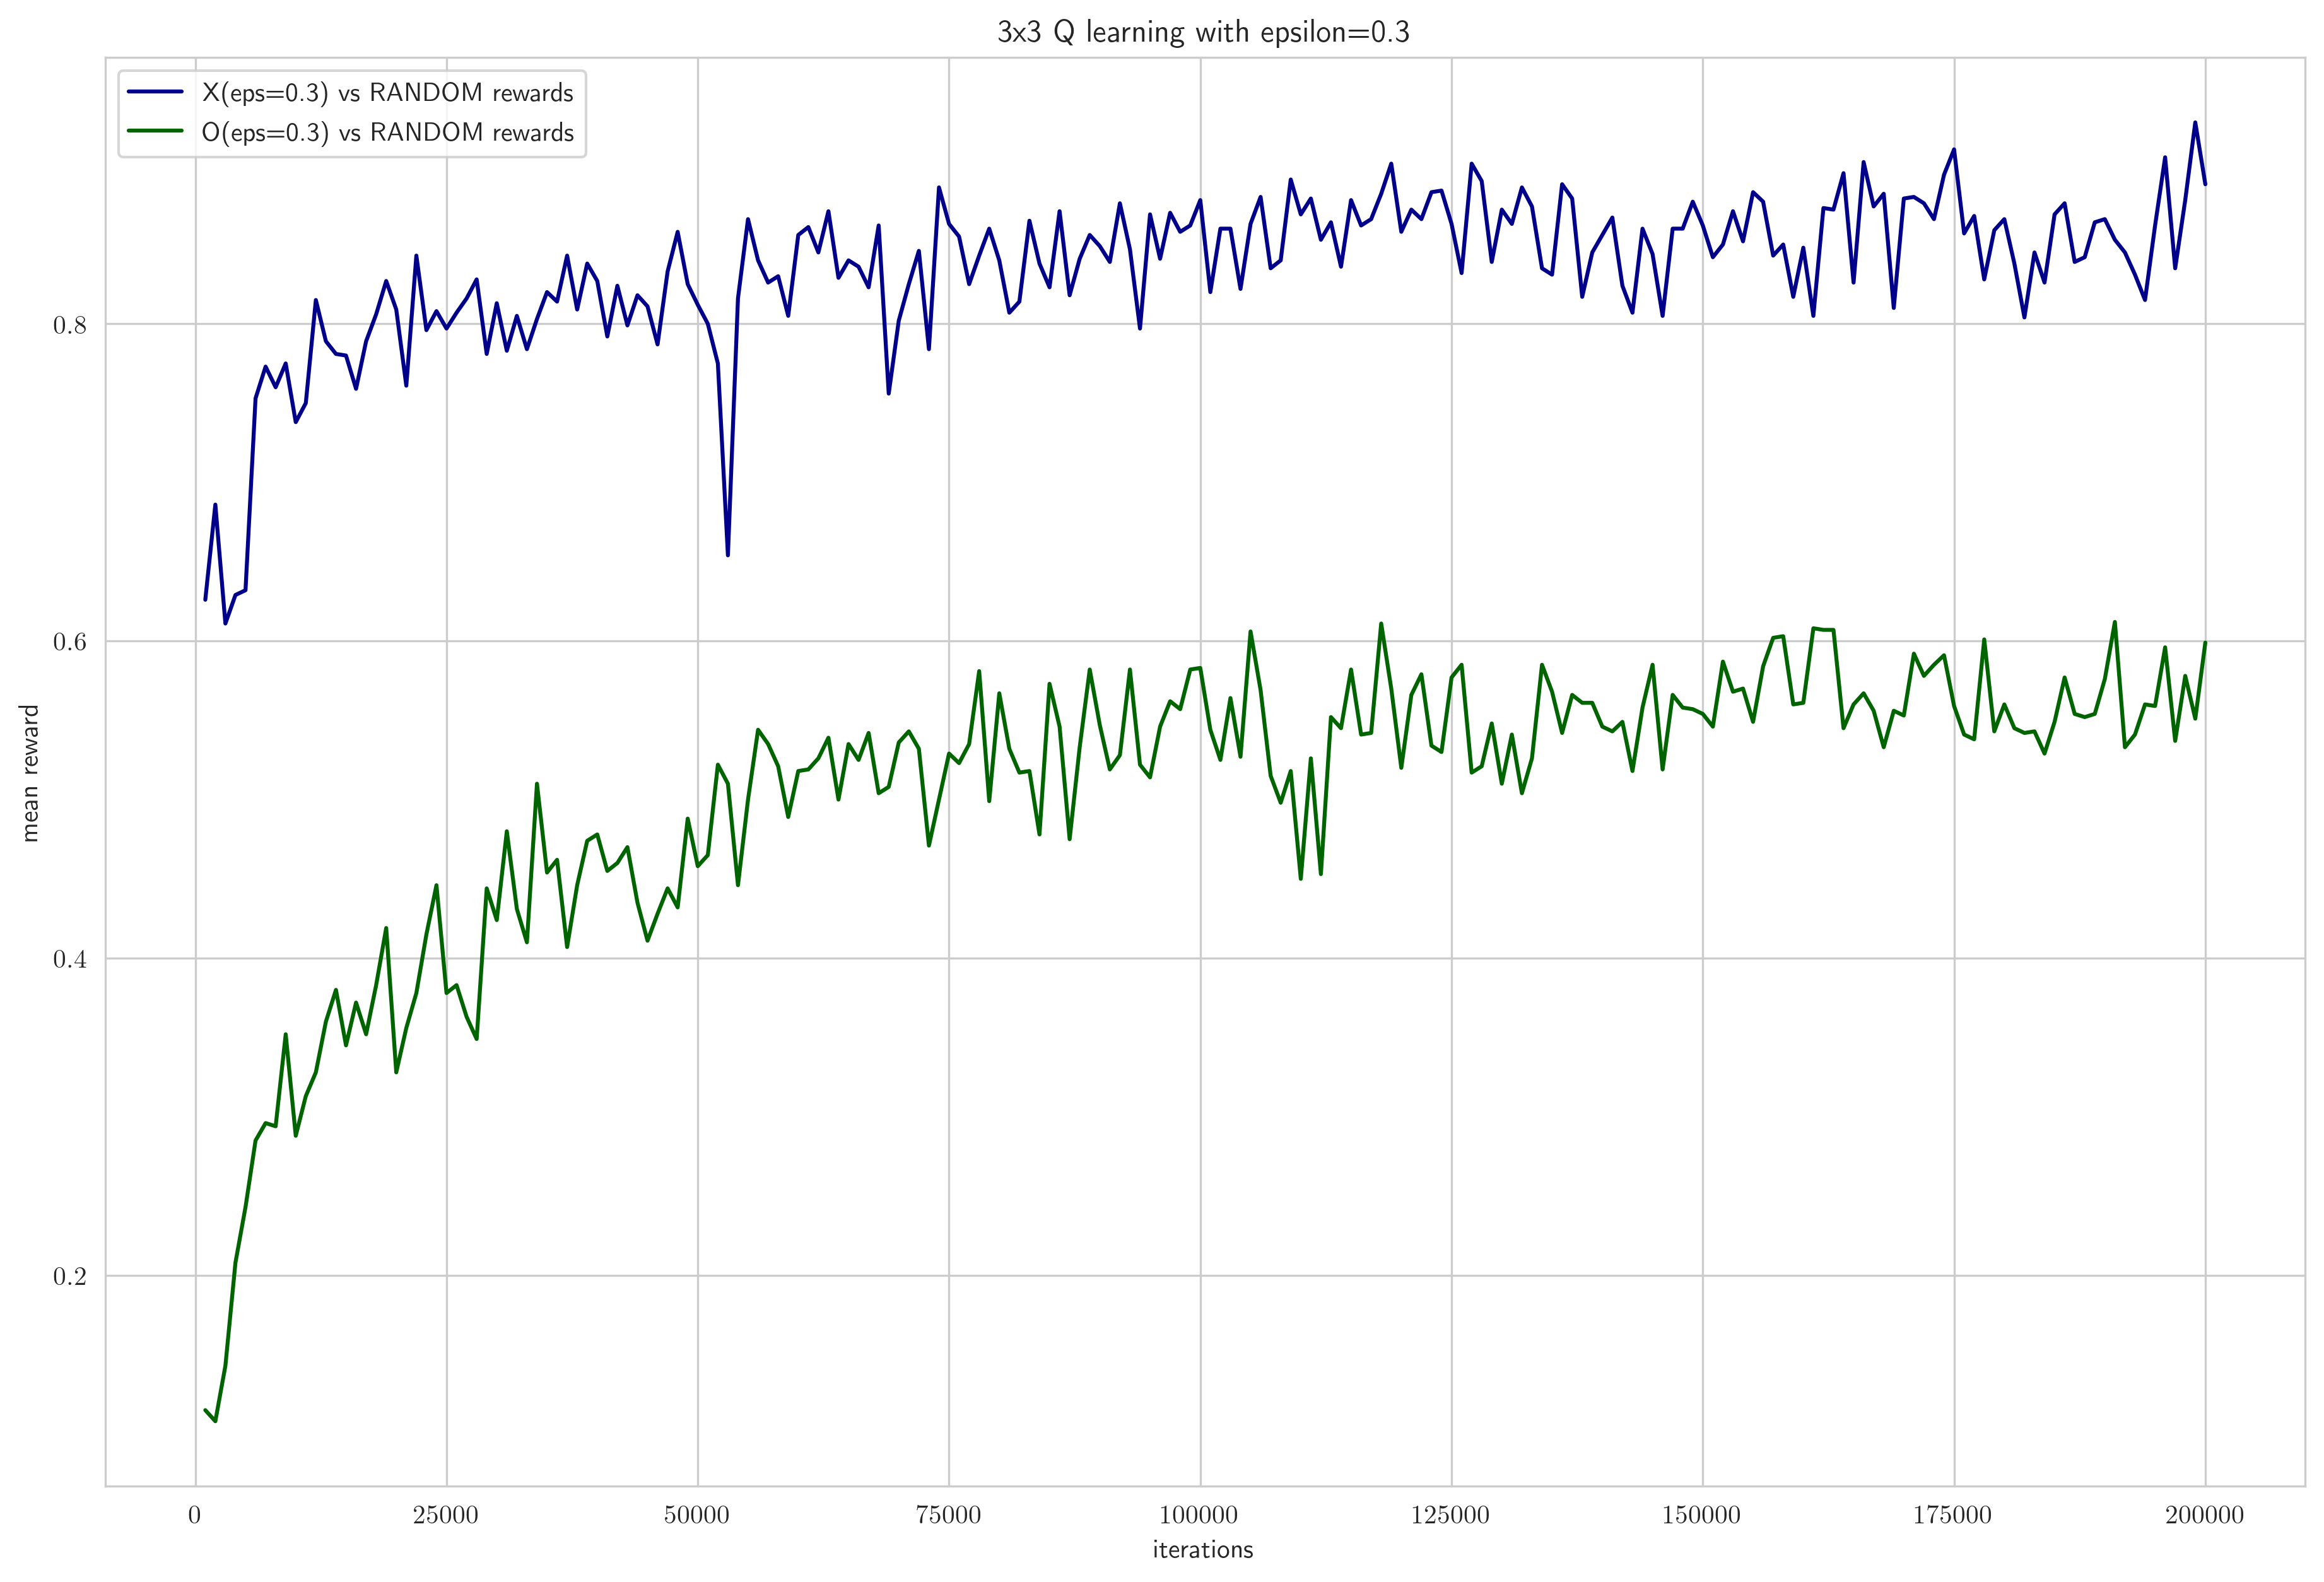

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X(eps={epsilon}) vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O(eps={epsilon}) vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
ax.legend()
ax.set_title(f'3x3 Q learning with epsilon={epsilon}')
ax.grid(True)

На доске 3х3 обе стратегии обучаются довольно быстро.

#### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Обучим на доске 4х4.

In [8]:
%%time
env = TicTacToe(4, 4, 4)

epsilon = 0.3
player_x = Player(epsilon=epsilon)
player_o = Player(epsilon=epsilon)

iterations = 2000000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

10000(2000000): [X: 0.306 | O: 0.13]
20000(2000000): [X: 0.363 | O: 0.131]
30000(2000000): [X: 0.294 | O: 0.099]
40000(2000000): [X: 0.381 | O: 0.108]
50000(2000000): [X: 0.358 | O: 0.064]
60000(2000000): [X: 0.388 | O: 0.052]
70000(2000000): [X: 0.407 | O: 0.076]
80000(2000000): [X: 0.416 | O: 0.118]
90000(2000000): [X: 0.383 | O: 0.077]
100000(2000000): [X: 0.4 | O: 0.1]
110000(2000000): [X: 0.395 | O: 0.126]
120000(2000000): [X: 0.385 | O: 0.117]
130000(2000000): [X: 0.349 | O: 0.106]
140000(2000000): [X: 0.409 | O: 0.127]
150000(2000000): [X: 0.441 | O: 0.054]
160000(2000000): [X: 0.453 | O: 0.065]
170000(2000000): [X: 0.42 | O: 0.106]
180000(2000000): [X: 0.402 | O: 0.119]
190000(2000000): [X: 0.395 | O: 0.111]
200000(2000000): [X: 0.446 | O: 0.106]
210000(2000000): [X: 0.428 | O: 0.081]
220000(2000000): [X: 0.402 | O: 0.107]
230000(2000000): [X: 0.419 | O: 0.121]
240000(2000000): [X: 0.396 | O: 0.114]
250000(2000000): [X: 0.415 | O: 0.147]
260000(2000000): [X: 0.494 | O: 0.109]
2

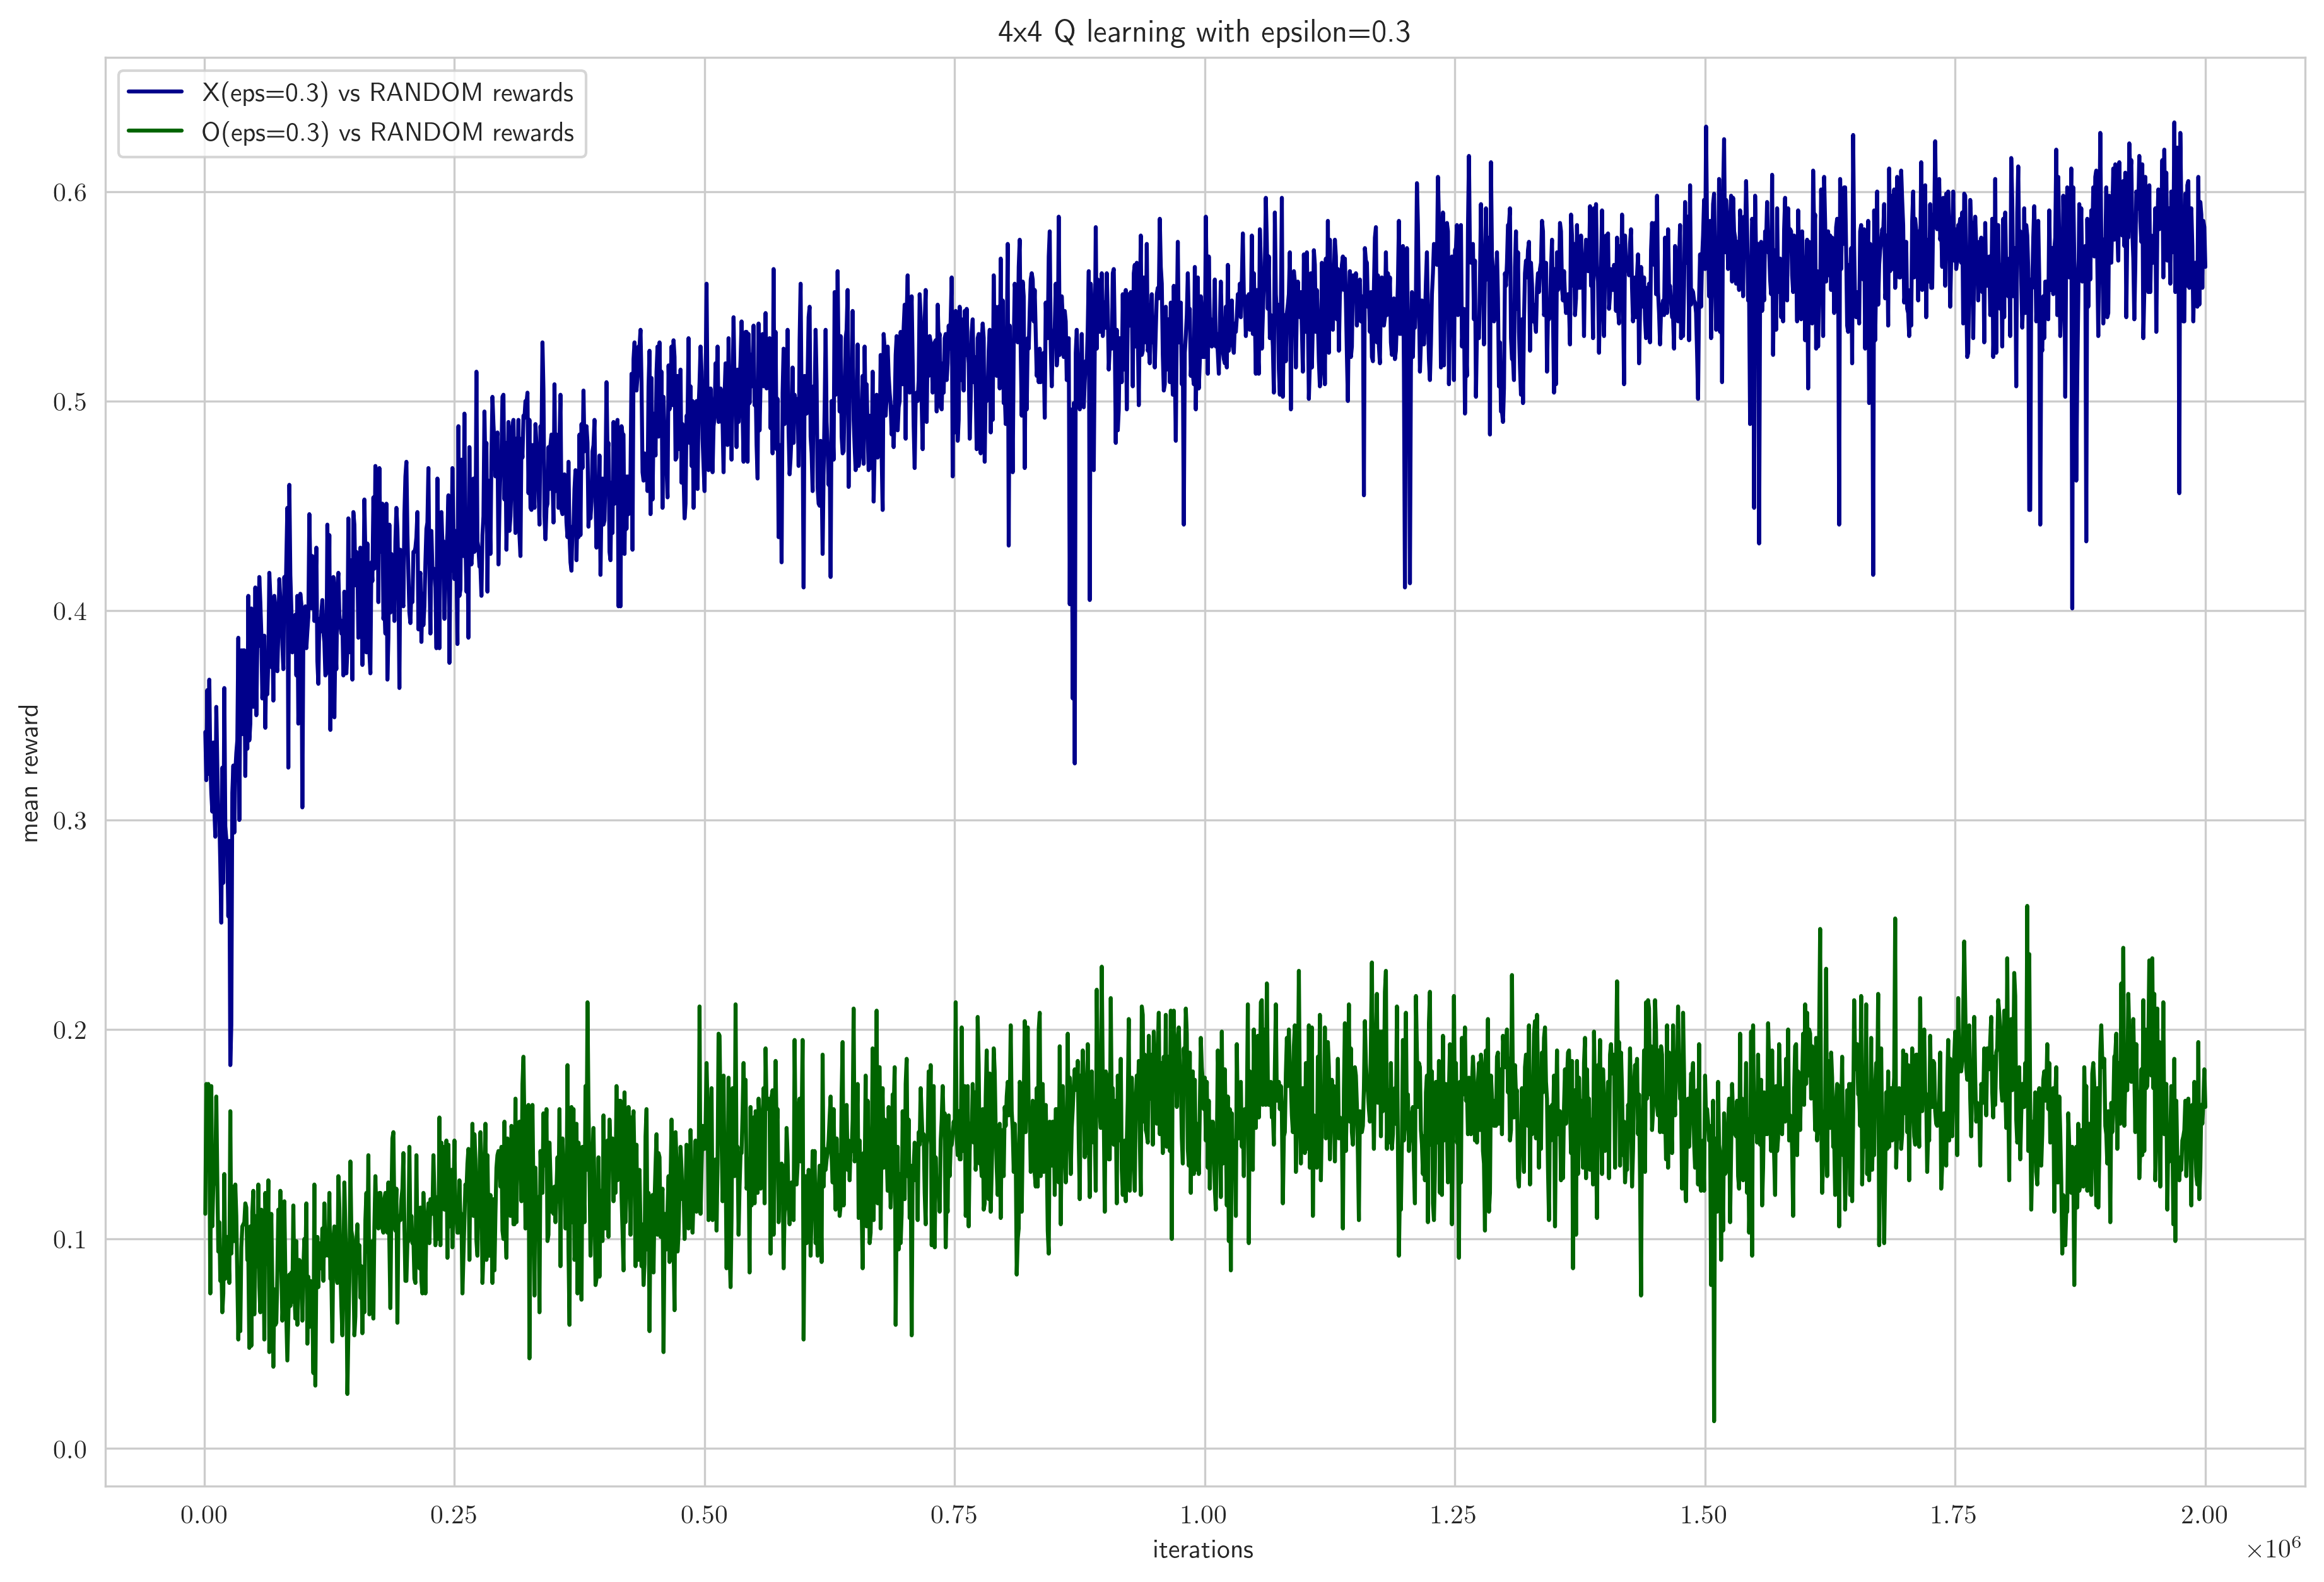

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X(eps={epsilon}) vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O(eps={epsilon}) vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
ax.legend()
ax.set_title(f'4x4 Q learning with epsilon={epsilon}')
ax.grid(True)

На доске 4х4 ситуация хуже. У крестиков видна положительная динамика, нолики застряли примерно на 0.2.

Обучим на доске 5х5.

In [15]:
%%time
env = TicTacToe(5, 5, 5)

epsilon = 0.3
player_x = Player(epsilon=epsilon)
player_o = Player(epsilon=epsilon)

iterations = 500000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

10000(500000): [X: 0.428 | O: 0.164]
20000(500000): [X: 0.418 | O: 0.177]
30000(500000): [X: 0.433 | O: 0.183]
40000(500000): [X: 0.43 | O: 0.196]
50000(500000): [X: 0.463 | O: 0.199]
60000(500000): [X: 0.453 | O: 0.164]
70000(500000): [X: 0.388 | O: 0.196]
80000(500000): [X: 0.411 | O: 0.163]
90000(500000): [X: 0.381 | O: 0.114]
100000(500000): [X: 0.397 | O: 0.202]
110000(500000): [X: 0.392 | O: 0.201]
120000(500000): [X: 0.442 | O: 0.117]
130000(500000): [X: 0.427 | O: 0.103]
140000(500000): [X: 0.411 | O: 0.152]
150000(500000): [X: 0.34 | O: 0.12]
160000(500000): [X: 0.447 | O: 0.106]
170000(500000): [X: 0.417 | O: 0.127]
180000(500000): [X: 0.5 | O: 0.152]
190000(500000): [X: 0.378 | O: 0.126]
200000(500000): [X: 0.458 | O: 0.098]
210000(500000): [X: 0.423 | O: 0.136]
220000(500000): [X: 0.452 | O: 0.158]
230000(500000): [X: 0.414 | O: 0.119]
240000(500000): [X: 0.416 | O: 0.151]
250000(500000): [X: 0.448 | O: 0.11]
260000(500000): [X: 0.489 | O: 0.125]
270000(500000): [X: 0.341 |

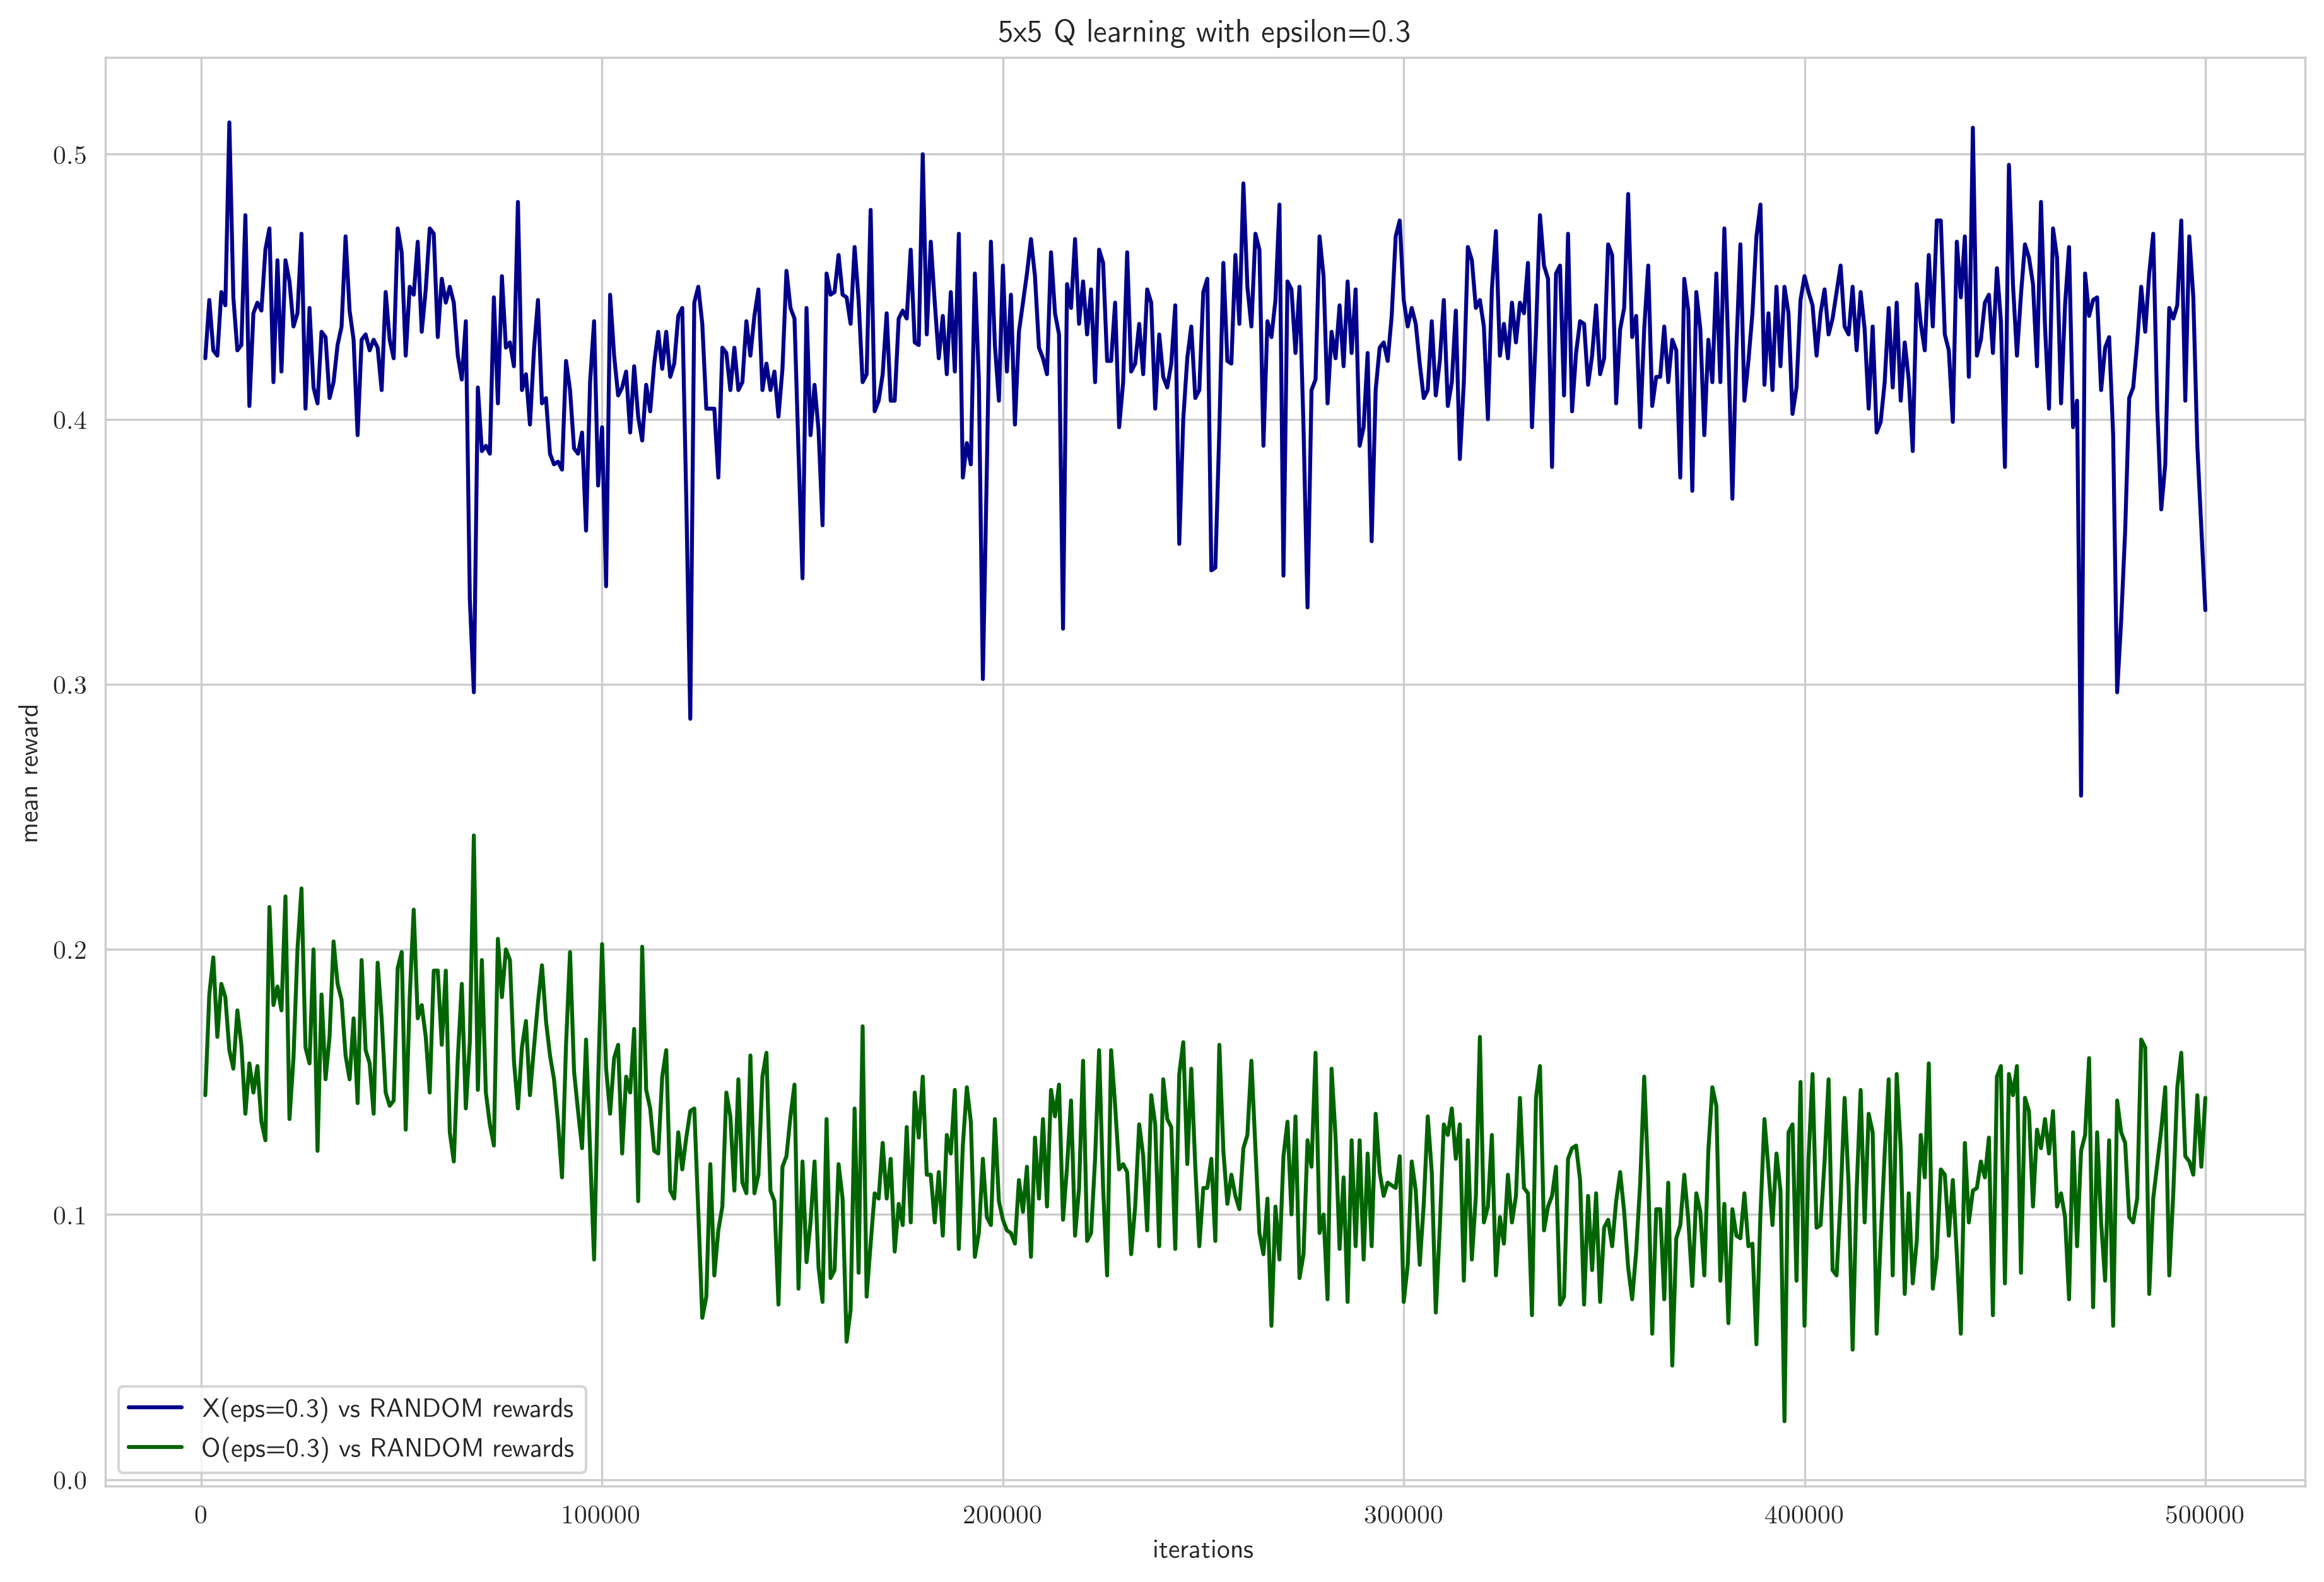

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X(eps={epsilon}) vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O(eps={epsilon}) vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
ax.legend()
ax.set_title(f'5x5 Q learning with epsilon={epsilon}')
ax.grid(True)

На доске 5х5 учится слишком долго и положительная динамика не наблюдается ни у крестиков, ни у ноликов.

### Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).<br>

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN. 

#### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов.

In [6]:
class QNetwork(nn.Module):
    def __init__(self, state_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, hidden_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_size*2, hidden_size, kernel_size=3, padding=1),
        )
        self.head = nn.Linear(state_size * hidden_size, state_size)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.shape[0], -1)
        x = self.head(x)
        return x

In [7]:
class ReplayBuffer:
    """Буфер для хранения накопленного опыта"""

    def __init__(self, buffer_size, batch_size):
        """
        buffer_size (int): Максимальный размер буфера
        batch_size (int): Размер батча
        """
        self.memory = deque(maxlen=buffer_size)  # Используем очередь для буфера
        self.batch_size = batch_size

    def consume_transition(self, transition):
        """Добавление нового опыта в память"""
        self.memory.append(transition)

    def sample_batch(self):
        """Сэмплируем батч из буфера случайным образом"""
        batch = random.choices(self.memory, k=self.batch_size)
        return list(zip(*batch))

In [8]:
BUFFER_SIZE = int(1e5) 
BATCH_SIZE = 128
INITIAL_STEPS = 1024
STEPS_PER_UPDATE = 4
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class DQNPlayer:
    def __init__(self, state_size, gamma=0.8):
        self.steps = 0
        self.device = DEVICE
        self.gamma = gamma
        self.batch_size = BATCH_SIZE
        self.initial_steps = INITIAL_STEPS
        self.steps_per_update = STEPS_PER_UPDATE
        self.model = QNetwork(state_size, 16).to(DEVICE)
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.optimizer = Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10000, gamma=0.8)
        self.epsilon_start = 0.9
        self.epsilon_finish = 0.05
        self.epsilon_decay = 2000

    def consume_transition(self, transition):
        self.replay_buffer.consume_transition(transition)

    def sample_batch(self):
        batch = self.replay_buffer.sample_batch()
        state, action, next_state, reward, done = batch
        state = torch.tensor(np.array(state, dtype=np.float32)).unsqueeze(1)
        action = torch.tensor(np.array(action, dtype=np.int64))
        next_state = torch.tensor(np.array(next_state, dtype=np.float32)).unsqueeze(1)
        reward = torch.tensor(np.array(reward, dtype=np.float32))
        done = torch.tensor(np.array(done, dtype=np.int32))
        return state, action, next_state, reward, done

    def train_step(self, batch):
        if not self.model.training:
            self.model.train()
        
        # Распаковываем наш батч
        state, action, next_state, reward, done = batch
        
        q_current = self.model(state.to(self.device))
        q_next = self.model(next_state.to(self.device))
        
        next_action = torch.argmax(q_next, 1)
        reward_current = q_current.gather(1, action.view(-1, 1).to(self.device))
        reward_next = q_next.gather(1, next_action.view(-1, 1)).squeeze(1) * (1 - done.to(self.device))
        
        loss = F.mse_loss(reward_current.squeeze(1), reward.to(self.device) + self.gamma * reward_next)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.steps > 1000000:
            self.scheduler.step(loss)
            
    @staticmethod
    def prepare_state(state):
        n = len(state)
        size = int(np.sqrt(n))
        state = list(map(lambda x: int(x)-1, state))
        state = np.array(state).reshape(size, size)
        return state
       
    def get_action(self, state):
        if self.model.training:
            self.model.eval()
            
        state = self.prepare_state(state)  # здесь нам нужен state в виде numpy array, а не string
        state = torch.tensor(np.array(state)).view(1, 1, state.shape[-2], state.shape[-1])
        state = state.float().to(self.device)
        
        action = self.model(state).detach().cpu().numpy()
        epsilon = self.epsilon_finish + (self.epsilon_start - self.epsilon_finish) * math.exp(-1. * self.steps / self.epsilon_decay)
        if random.random() > epsilon:
            index = np.argmax(action.squeeze())
        else:
            index = random.choice(list(range(len(action.squeeze()))))
        return index // state.shape[-1], index % state.shape[-1]

    def update_Q(self, state, action, next_state, reward, done):
        if next_state is None:
            next_state = state
        state = self.prepare_state(state)
        next_state = self.prepare_state(next_state)
        
        action = action[0] * state.shape[-1] + action[1]
        self.consume_transition((state, action, next_state, reward, done))
        self.steps += 1
        if self.steps > self.initial_steps:
            if self.steps % self.steps_per_update == 0:
                batch = self.sample_batch()
                self.train_step(batch)

Обучим для доски 3х3.

In [35]:
%%time
env = TicTacToe(3, 3, 3)

player_x = DQNPlayer(state_size=9)
player_o = DQNPlayer(state_size=9)

iterations = 50000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

 20%|██        | 10019/50000 [02:25<1:30:11,  7.39it/s]

10000(50000): [X: 0.421 | O: -6.343]


 40%|████      | 20013/50000 [05:24<1:29:41,  5.57it/s]

20000(50000): [X: 0.854 | O: -0.827]


 60%|██████    | 30007/50000 [08:50<1:10:16,  4.74it/s]

30000(50000): [X: 0.875 | O: -0.547]


 80%|████████  | 40010/50000 [12:25<40:02,  4.16it/s]  

40000(50000): [X: 0.856 | O: -0.318]


100%|██████████| 50000/50000 [16:05<00:00, 51.80it/s]

50000(50000): [X: 0.881 | O: -0.072]
CPU times: user 15min 57s, sys: 14.4 s, total: 16min 12s
Wall time: 16min 5s


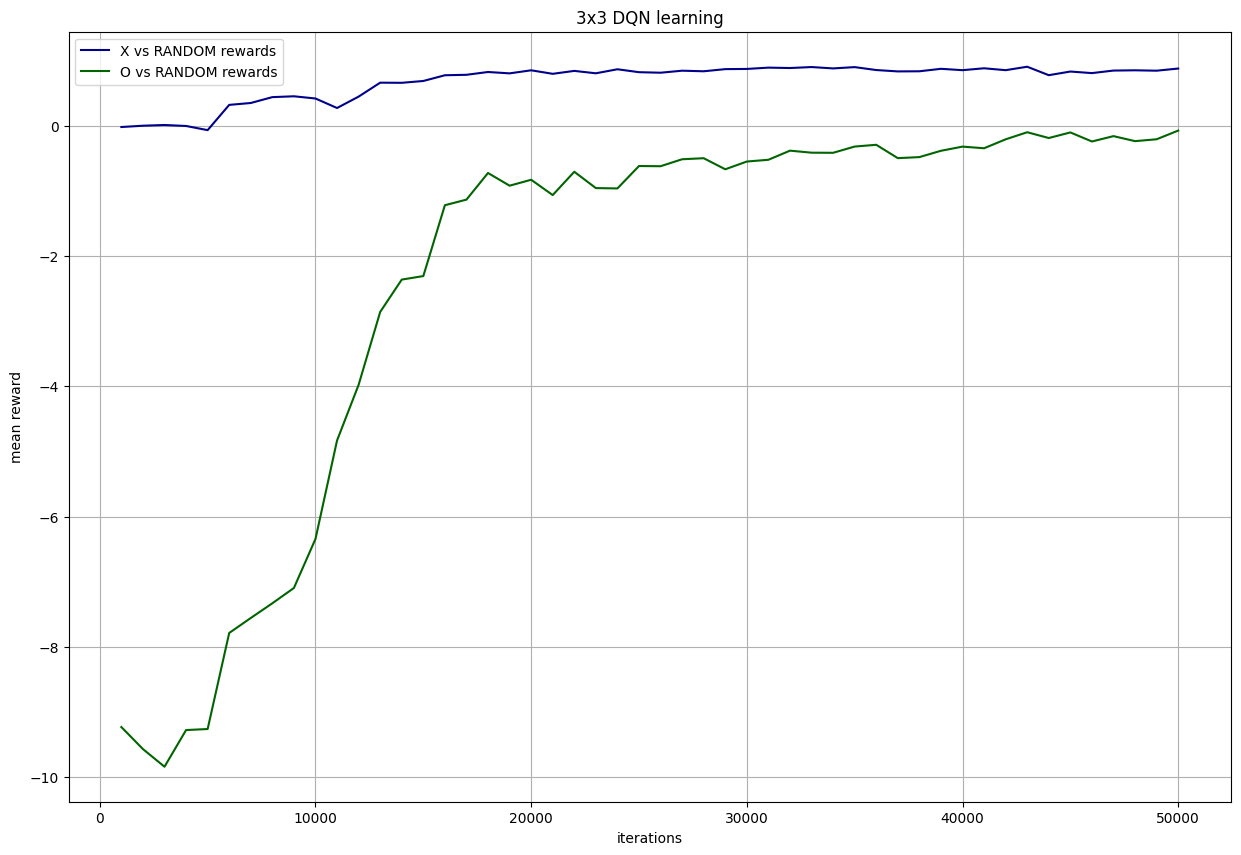

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label='X vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label='O vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
#ax.set_ylim([-1,1])
ax.legend()
ax.set_title('3x3 DQN learning')
ax.grid(True)

У крестиков получился хороший результат 0.88, а вот ноликам, видимо, не хватило дистанции. Положительная динамика видна, но слабо.

Обучим на доске 4х4.

In [37]:
%%time
env = TicTacToe(4, 4, 4)

player_x = DQNPlayer(state_size=16)
player_o = DQNPlayer(state_size=16)

iterations = 50000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

 20%|██        | 10005/50000 [04:14<4:56:36,  2.25it/s]

10000(50000): [X: 0.207 | O: -5.238]


 40%|████      | 20003/50000 [09:45<7:18:42,  1.14it/s]

20000(50000): [X: 0.51 | O: -1.3]


 60%|██████    | 30006/50000 [15:37<2:38:06,  2.11it/s] 

30000(50000): [X: 0.764 | O: -0.732]


 80%|████████  | 40004/50000 [21:09<1:25:18,  1.95it/s]

40000(50000): [X: 0.785 | O: -0.858]


100%|██████████| 50000/50000 [26:49<00:00, 31.07it/s]  

50000(50000): [X: 0.725 | O: -0.681]
CPU times: user 26min 35s, sys: 25.3 s, total: 27min
Wall time: 26min 49s


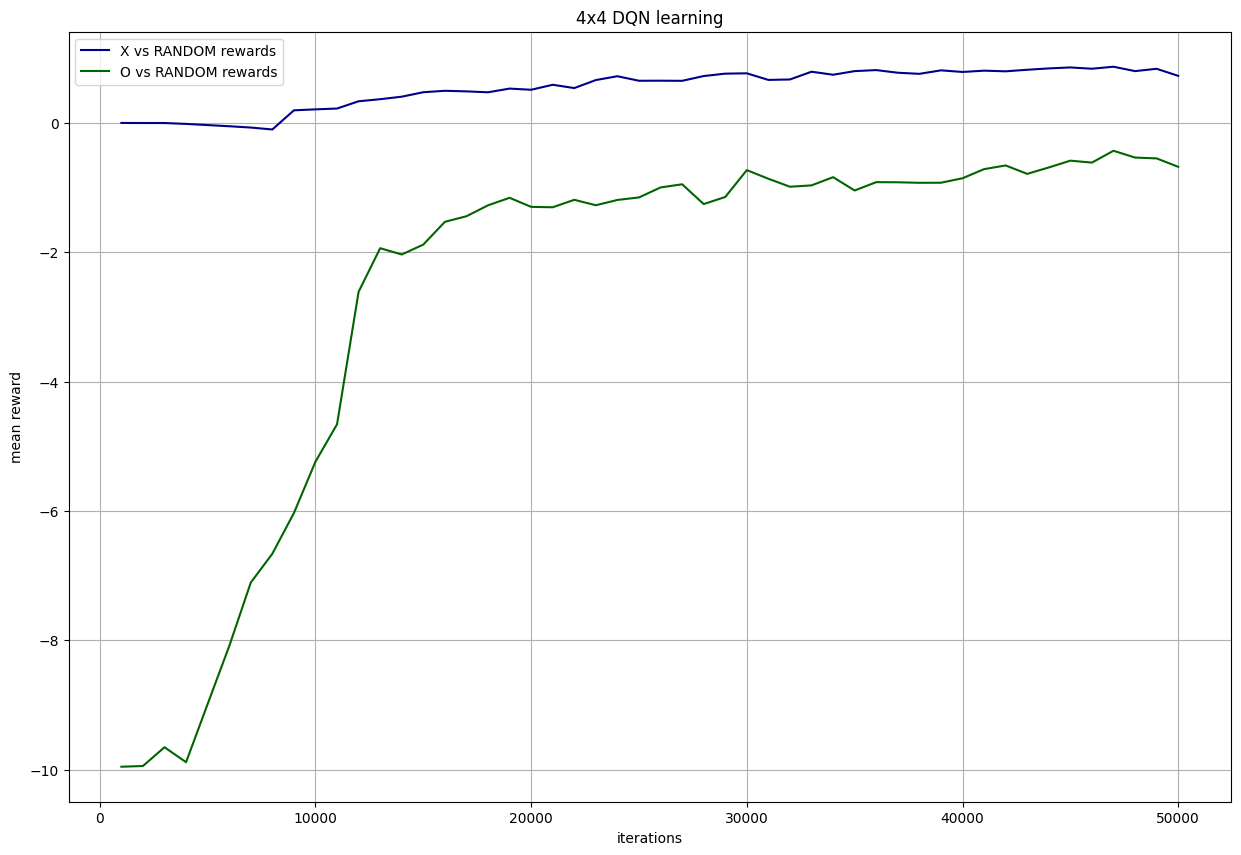

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
#ax.set_ylim([-2,1])
ax.legend()
ax.set_title(f'4x4 DQN learning')
ax.grid(True)

На доске 4х4 ситуация немного хуже, но примерно такая же, как и на доске 3х3. Также у ноликов слабая положительная динамика, нужно больше итераций.

Обучим на доске 5х5.

In [39]:
%%time
env = TicTacToe(5, 5, 5)

player_x = DQNPlayer(state_size=25)
player_o = DQNPlayer(state_size=25)

iterations = 20000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

 50%|█████     | 10003/20000 [06:05<3:54:25,  1.41s/it]

10000(20000): [X: 0.292 | O: -2.15]


100%|██████████| 20000/20000 [14:32<00:00, 22.92it/s]  

20000(20000): [X: 0.644 | O: -2.025]
CPU times: user 14min 27s, sys: 11.4 s, total: 14min 38s
Wall time: 14min 33s


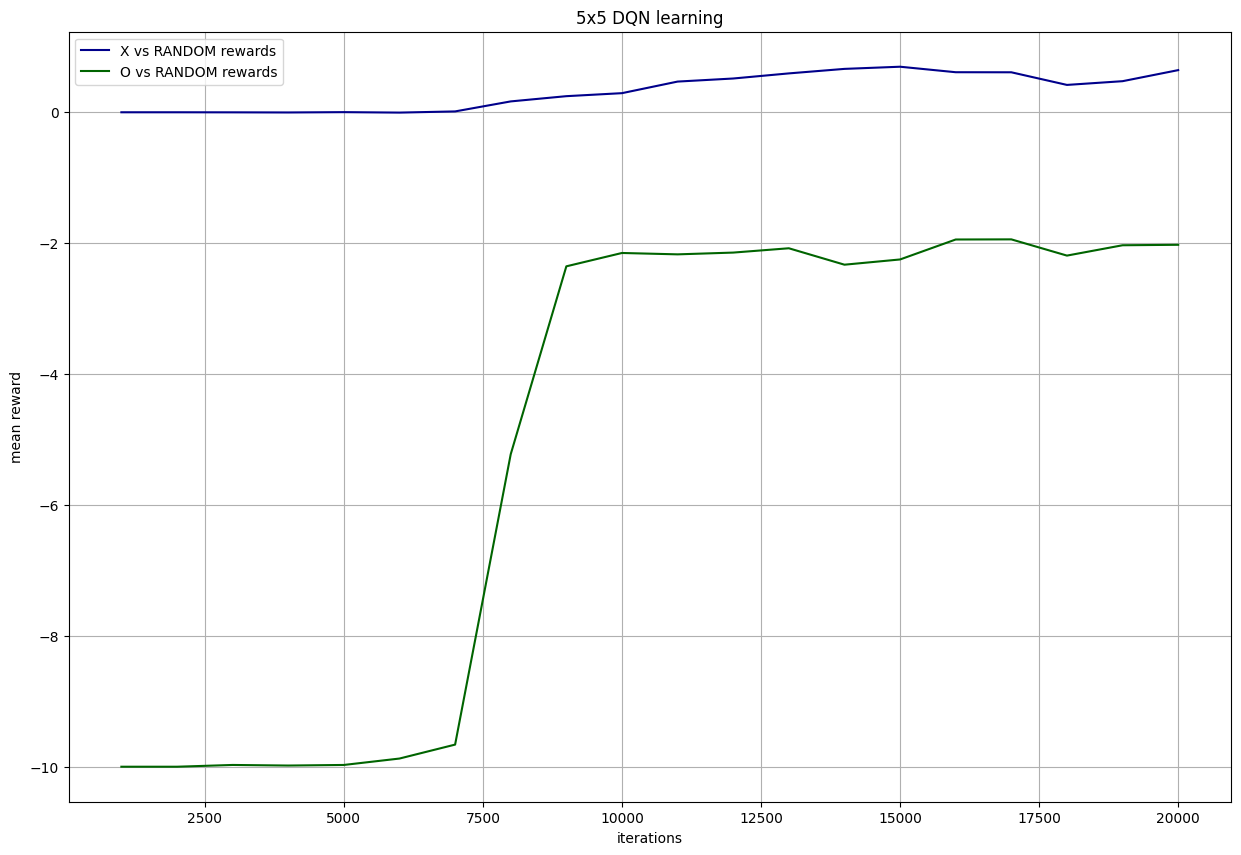

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
#ax.set_ylim([-1,1])
ax.legend()
ax.set_title(f'5x5 DQN learning')
ax.grid(True)

На доске 5х5 у крестиков все еще сравнительно неплохой результат 0.64, а вот нолики вообще отказались обучаться.

#### 4. Реализуйте Double DQN и/или Dueling DQN.

In [41]:
STEPS_PER_TARGET_UPDATE = 500
LEARNING_RATE = 1e-4

In [42]:
class DDQNPlayer:
    def __init__(self, state_size, gamma=0.7):
        self.steps = 0
        self.device = DEVICE
        self.gamma = gamma
        self.batch_size = BATCH_SIZE
        self.initial_steps = INITIAL_STEPS
        self.steps_per_update = STEPS_PER_UPDATE
        self.steps_per_target_update = STEPS_PER_TARGET_UPDATE
        self.model = QNetwork(state_size, 16).to(DEVICE)
        self.target_model = QNetwork(state_size, 16).to(DEVICE)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.optimizer = Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10000, gamma=0.8)
        self.epsilon_start = 0.9
        self.epsilon_finish = 0.05
        self.epsilon_decay = 2000
    
    def consume_transition(self, transition):
        self.replay_buffer.consume_transition(transition)

    def sample_batch(self):
        batch = self.replay_buffer.sample_batch()
        state, action, next_state, reward, done = batch
        state = torch.tensor(np.array(state, dtype=np.float32)).unsqueeze(1)
        action = torch.tensor(np.array(action, dtype=np.int64))
        next_state = torch.tensor(np.array(next_state, dtype=np.float32)).unsqueeze(1)
        reward = torch.tensor(np.array(reward, dtype=np.float32))
        done = torch.tensor(np.array(done, dtype=np.int32))
        return state, action, next_state, reward, done
    
    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
    
    def train_step(self, batch):
        if not self.model.training:
            self.model.train()
        
        # Распаковываем наш батч
        state, action, next_state, reward, done = batch
        
        q_current = self.model(state.to(self.device))
        q_next = self.model(next_state.to(self.device))
        with torch.no_grad():
            target_q_next = self.target_model(next_state.to(self.device))
        
        next_action = torch.argmax(q_next, 1)
        reward_current = q_current.gather(1, action.view(-1, 1).to(self.device))
        reward_next = target_q_next.gather(1, next_action.view(-1, 1)).squeeze(1) * (1 - done.to(self.device))
        
        loss = F.mse_loss(reward_current.squeeze(1), reward.to(self.device) + self.gamma * reward_next)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.steps > 1000000:
            self.scheduler.step(loss)
            
    @staticmethod
    def prepare_state(state):
        n = len(state)
        size = int(np.sqrt(n))
        state = list(map(lambda x: int(x)-1, state))
        state = np.array(state).reshape(size, size)
        return state
       
    def get_action(self, state):
        if self.model.training:
            self.model.eval()
            
        state = self.prepare_state(state)  # здесь нам нужен state в виде numpy array, а не string
        state = torch.tensor(np.array(state)).view(1, 1, state.shape[-2], state.shape[-1])
        state = state.float().to(self.device)
        
        action = self.model(state).detach().cpu().numpy()
        epsilon = self.epsilon_finish + (self.epsilon_start - self.epsilon_finish) * math.exp(-1. * self.steps / self.epsilon_decay)
        if random.random() > epsilon:
            index = np.argmax(action.squeeze())
        else:
            index = random.choice(list(range(len(action.squeeze()))))
        return index // state.shape[-1], index % state.shape[-1]
    
    def update_Q(self, state, action, next_state, reward, done):
        if next_state is None:
            next_state = state
        state = self.prepare_state(state)
        next_state = self.prepare_state(next_state)
        
        action = action[0] * state.shape[-1] + action[1]
        self.consume_transition((state, action, next_state, reward, done))
        self.steps += 1
        if self.steps > self.initial_steps:
            if self.steps % self.steps_per_update == 0:
                batch = self.sample_batch()
                self.train_step(batch)
            if self.steps % self.steps_per_target_update == 0:
                self.update_target_network()

Обучим для доски 3х3.

In [43]:
%%time
env = TicTacToe(3, 3, 3)

player_x = DDQNPlayer(state_size=9)
player_o = DDQNPlayer(state_size=9)

iterations = 50000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

 20%|██        | 10009/50000 [02:29<2:33:47,  4.33it/s]

10000(50000): [X: 0.072 | O: -1.475]


 40%|████      | 20010/50000 [05:40<1:33:00,  5.37it/s]

20000(50000): [X: 0.616 | O: -0.251]


 60%|██████    | 30008/50000 [08:58<1:17:41,  4.29it/s]

30000(50000): [X: 0.834 | O: -0.118]


 80%|████████  | 40012/50000 [12:19<30:22,  5.48it/s]  

40000(50000): [X: 0.918 | O: 0.044]


100%|██████████| 50000/50000 [15:58<00:00, 52.17it/s]

50000(50000): [X: 0.867 | O: -0.02]
CPU times: user 15min 51s, sys: 14.7 s, total: 16min 5s
Wall time: 15min 58s


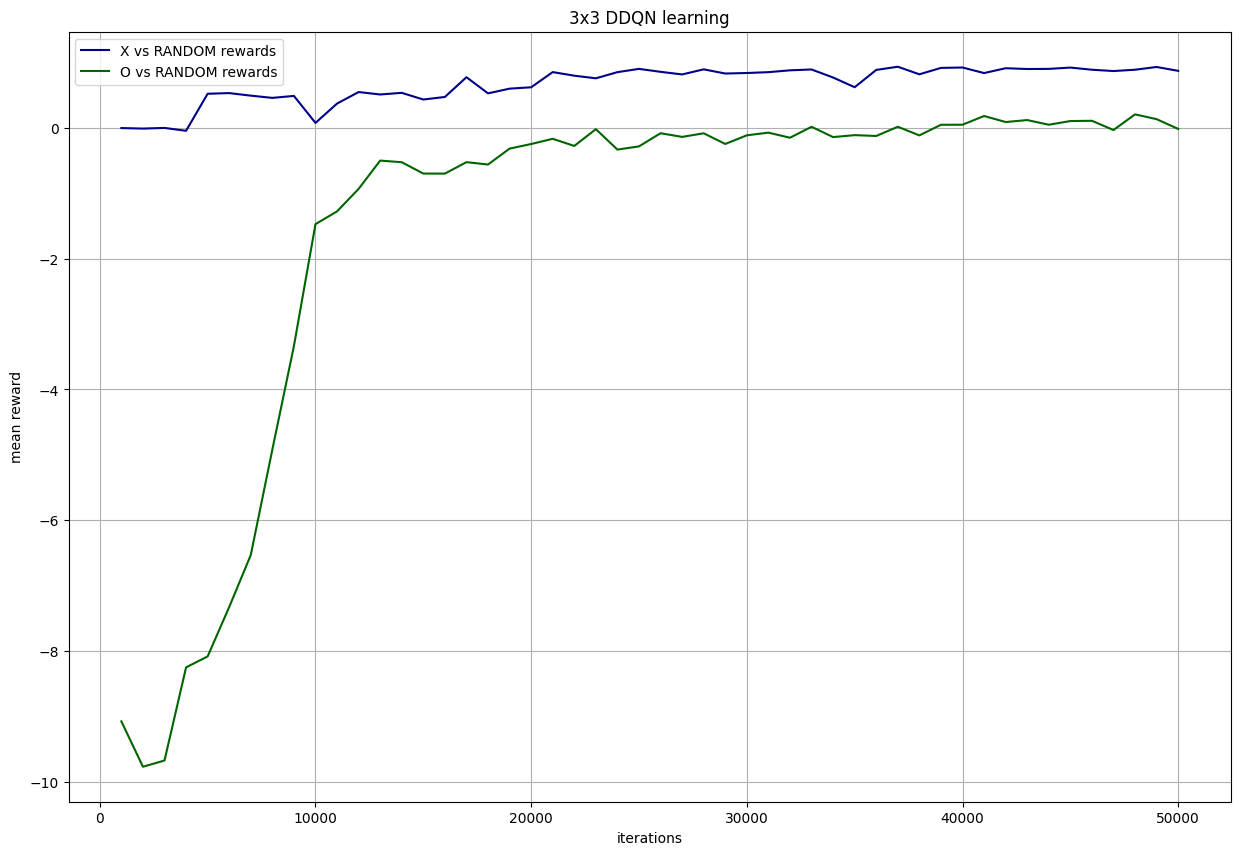

In [44]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
#ax.set_ylim([-2,1])
ax.legend()
ax.set_title(f'3x3 DDQN learning')
ax.grid(True)

Здесь крестики обучились примерно так же, как и в DQN. А ноликам стало немного получше, они даже успели выйти в плюс.

Обучим на доске 4х4.

In [45]:
%%time
env = TicTacToe(4, 4, 4)

player_x = DDQNPlayer(state_size=16)
player_o = DDQNPlayer(state_size=16)

iterations = 30000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

 33%|███▎      | 10007/30000 [04:18<3:07:33,  1.78it/s]

10000(30000): [X: 0.221 | O: -1.35]


 67%|██████▋   | 20007/30000 [09:44<1:02:18,  2.67it/s]

20000(30000): [X: 0.699 | O: -0.969]


100%|██████████| 30000/30000 [14:54<00:00, 33.53it/s]  

30000(30000): [X: 0.818 | O: -0.414]
CPU times: user 14min 52s, sys: 9.01 s, total: 15min 1s
Wall time: 14min 55s


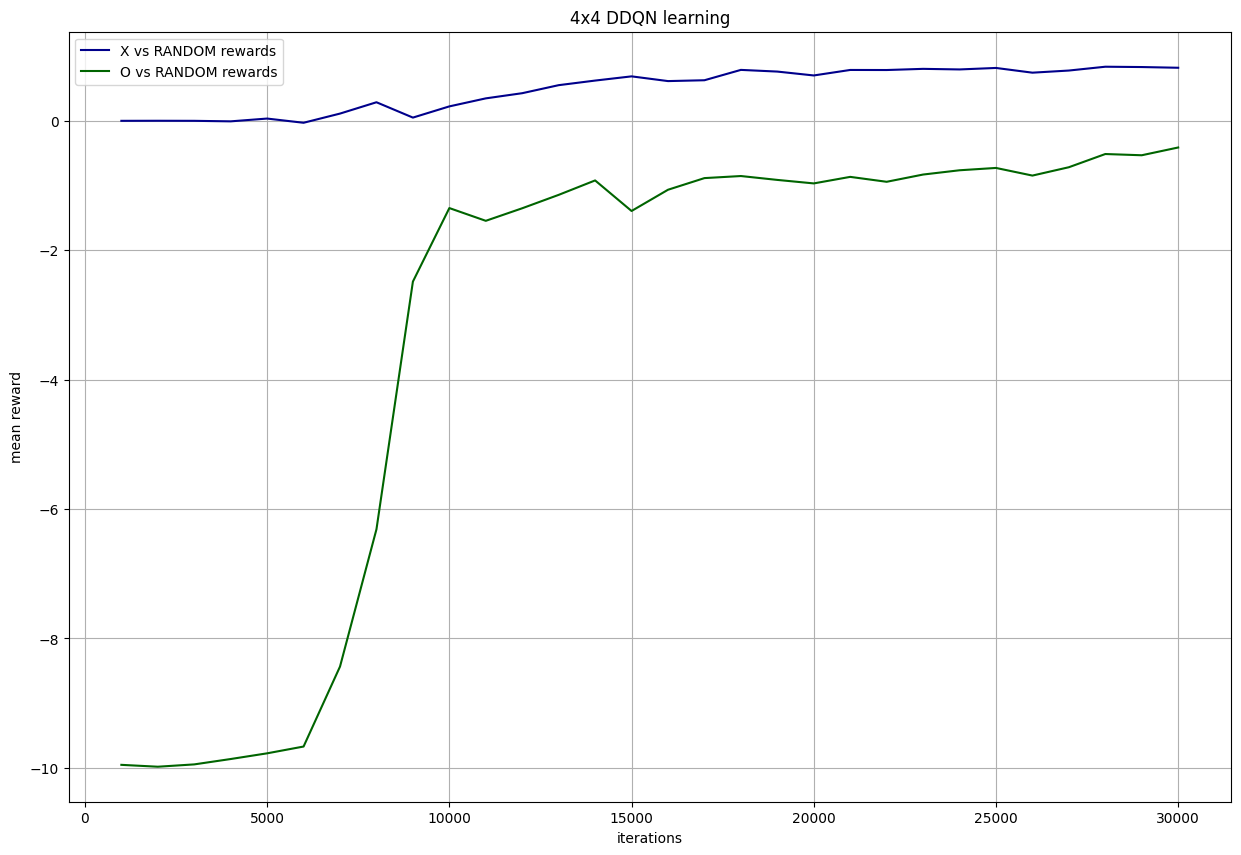

In [46]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
#ax.set_ylim([-2,1])
ax.legend()
ax.set_title(f'4x4 DDQN learning')
ax.grid(True)

Тут тоже ситуация такая же, как и в DQN, только показатели немного выше.

Обучим на доске 5х5.

In [47]:
%%time
env = TicTacToe(5, 5, 5)

player_x = DDQNPlayer(state_size=25)
player_o = DDQNPlayer(state_size=25)

iterations = 20000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

 50%|█████     | 10004/20000 [06:48<3:00:23,  1.08s/it]

10000(20000): [X: 0.363 | O: -2.391]


100%|██████████| 20000/20000 [14:52<00:00, 22.41it/s]  

20000(20000): [X: 0.695 | O: -1.621]
CPU times: user 14min 49s, sys: 9.62 s, total: 14min 58s
Wall time: 14min 52s


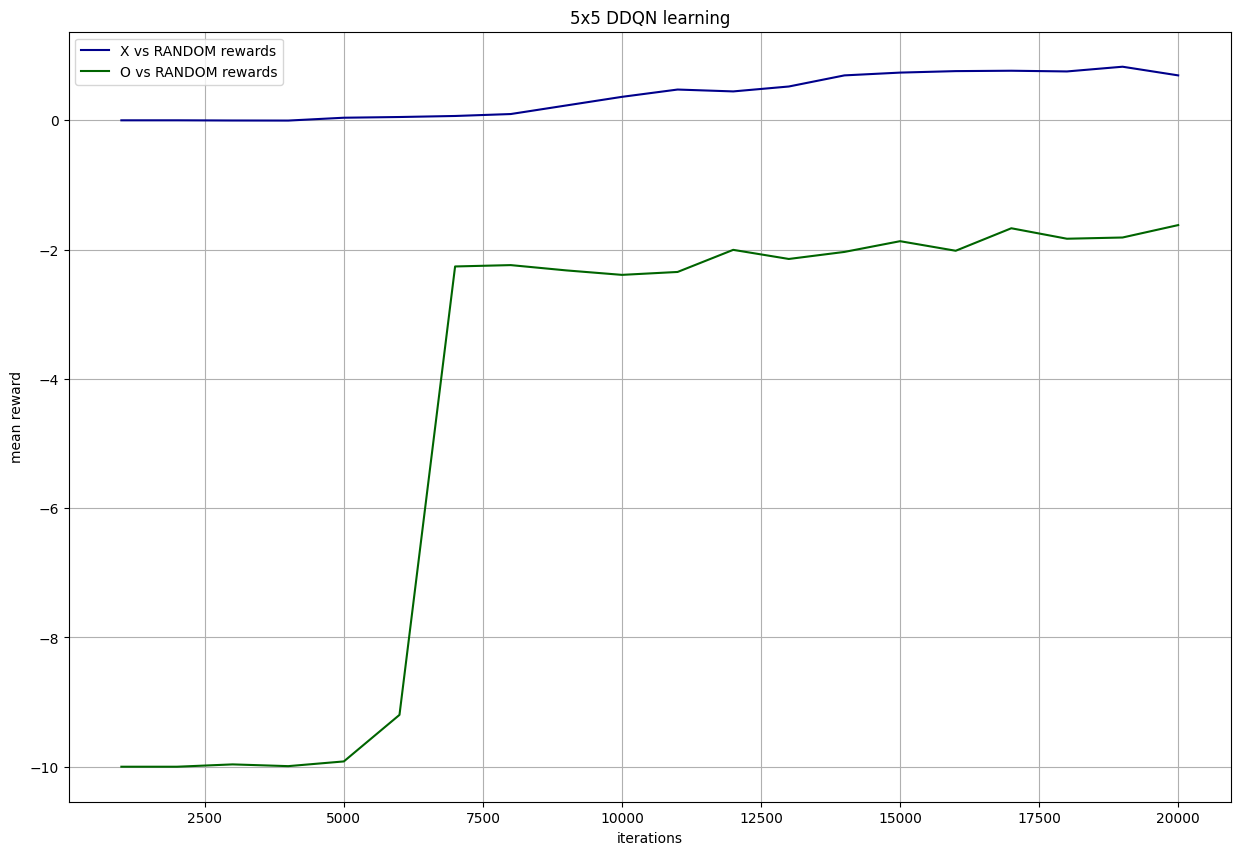

In [48]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
#ax.set_ylim([-3,1])
ax.legend()
ax.set_title(f'5x5 DDQN learning')
ax.grid(True)

Здесь нолики даже не сдались и все еще вытаются чему-то научиться.

### Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.<br>

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

#### 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [49]:
class Rollouts:
    def __init__(self, env, player, num_rolouts=50, rollout_with_random=True):
        self.env = env
        self.player = player
        self.n_rollouts = num_rolouts
        self.random_player = Player(epsilon=1)
        self.rollout_with_random = rollout_with_random
        
    def rollout(self, env, rollout_id):
        current_env = copy.deepcopy(env)
        state, empty_spaces, turn = current_env.getState()
        reward_coef = -turn
        done = False
        player_id = 0 if reward_coef == 1 else 1
        while not done:
            if self.rollout_with_random:
                if player_id == rollout_id:
                    action = self.player.get_action(state)
                else:
                    action = self.random_player.get_action(state)
            else:
                action = self.player.get_action(state)
            (state, empty_spaces, turn), reward, done, _ = current_env.step(action)
            player_id = 1 if player_id == 0 else 0
        return reward * reward_coef
    
    @staticmethod
    def get_actions_space(state):
        state_array = np.array(list(state))
        return np.where(state_array == '1')[0]
    
    def get_action_from_rollouts(self, rollout_id, n_iters=1):
        current_env = copy.deepcopy(self.env)
        state, empty_spaces, turn = current_env.getState()
        reward_coef = turn
        empty_actions = self.get_actions_space(state)
        rollout_results = {}
        for action in empty_actions:
            current_env = copy.deepcopy(self.env)
            action_tuple = current_env.action_from_int(action)
            (state, empty_spaces, turn), reward, done, _ = current_env.step(action_tuple)
            if not done:
                rollout_results[action] = np.mean([self.rollout(current_env, rollout_id) for _ in range(n_iters)])
            else:
                rollout_results[action] = reward * reward_coef

        best_action = max(rollout_results, key=rollout_results.get)
        return best_action
    
    def run_episode(self, rollout_id):
        self.env.reset()
        state, empty_spaces, turn = self.env.getState()
        done = False
        player_id = 0

        while not done:
            if player_id == rollout_id:
                action = self.get_action_from_rollouts(rollout_id, n_iters=self.n_rollouts)
                action = self.env.action_from_int(action)
            else:
                action = self.random_player.get_action(state)
            (state, empty_spaces, turn), reward, done, _ = self.env.step(action)
            player_id = 1 if player_id == 0 else 0

        return reward
    
    def evaluate(self, iterations):
        rewards_0 = []
        rewards_1 = []
        for i in tqdm(range(iterations)):
            rewards_0.append(self.run_episode(0))
            rewards_1.append(-1 * self.run_episode(1))
        return np.mean(rewards_0), np.mean(rewards_1)

Проверим для доски 3х3

Сначала для игрока с рандомной стратегией.

In [50]:
env = TicTacToe(3, 3, 3)

player = Player(epsilon=1)

iterations = 1000

rollouts_game = Rollouts(env, player)
rewards_x, rewards_o = rollouts_game.evaluate(iterations)
print(f'Random players 3x3: [X: {round(rewards_x, 2)} | O: {round(rewards_o, 2)}]')

100%|██████████| 1000/1000 [12:10<00:00,  1.37it/s]

Random players 3x3: [X: 0.99 | O: 0.82]


Обучим игрока по стратегии Q-learning на небольшом количестве итераций

In [51]:
%%time
env = TicTacToe(3, 3, 3)
player_1 = Player(epsilon=0.3)
player_2 = Player(epsilon=0.3)

iterations = 10000
game = Game(env, player_1, player_1)

steps, rewards_1, rewards_2 = game.train(iterations)

100%|██████████| 10000/10000 [00:19<00:00, 520.66it/s]

10000(10000): [X: 0.727 | O: 0.176]
CPU times: user 18.7 s, sys: 516 ms, total: 19.3 s
Wall time: 19.2 s


In [52]:
env = TicTacToe(3, 3, 3)

player = player_1

iterations = 1000

rollouts_game = Rollouts(env, player)
rewards_x, rewards_o = rollouts_game.evaluate(iterations)
print(f'Qlearning player vs random player 3x3: [X: {round(rewards_x, 2)} | O: {round(rewards_o, 2)}]')

100%|██████████| 1000/1000 [11:39<00:00,  1.43it/s]

Qlearning player vs random player 3x3: [X: 0.96 | O: 0.74]


#### 6. Реализуйте MCTS-поиск с rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [53]:
EXPLORATION = math.sqrt(2)

In [54]:
class Node:
    def __init__(self, state, action, player_id, parent=None, is_new=True):
        self.state = state
        self.action = action
        self.parent = parent
        self.player_id = player_id
        self.node_vals = [0, 0]
        self.visits = 0
        self.children = []
        self.is_new = is_new
        self.is_terminal = False
        
    def value(self):
        if self.visits == 0:
            return 0
        
        val = self.node_vals[self.player_id] / self.visits
        return val

In [55]:
class MCTS:
    def __init__(self, env, player_id, player):
        self.env = env
        self.size = self.env.n_rows
        self.C = EXPLORATION
        self.random_player = Player(epsilon=1)
        self.player = player
        self.policy = self.player.get_action
        self.policy_random = self.random_player.get_action
        self.player_id = player_id
        self.env.reset()
        state, empty_spaces, turn = self.env.getState()
        self.root = Node(state=state, action=None, player_id=player_id, parent=None, is_new=False)
         
    @staticmethod
    def get_new_state(s, action, player_id):
        action_str = '2' if player_id == 0 else '0'
        new_hash = s[:action] + action_str + s[action + 1:]
        return new_hash
    
    
    def evaluate_tree(self, num_games=1000):
        rewards = []
        for _ in range(num_games):
            node = self.root
            self.env.reset()
            state, empty_spaces, turn = self.env.getState()
            done = False
            player_id = 0
            while not done:
                if node.children:
                    if player_id != self.player_id:
                        child = random.choice(node.children)
                    else:
                        child = max(node.children, key=lambda x: x.value())
                    node = child
                    action = child.action
                    action = self.env.action_from_int(action)
                else:
                    action = self.random_policy(state)
                    
                (state, empty_spaces, turn), reward, done, _ = self.env.step(action)
                player_id = 1 if player_id == 0 else 0
            rewards.append(reward)
        return rewards.count(1) / num_games, rewards.count(-1) / num_games, rewards.count(0) / num_games
    
    @staticmethod
    def backprop(node, vals):
        while node is not None:
            node.node_vals[0] += vals[0]
            node.node_vals[1] += vals[1]
            node.visits += 1
            node = node.parent
            
    def get_child_ucb(self, node):
        ucbs = []
        for child in node.children:
            ucb = child.value() + self.C * np.sqrt(np.log(node.visits) / child.visits)
            ucbs.append(ucb)
        ucb_idx = np.argmax(ucbs)
        best_child = node.children[ucb_idx]
        return best_child
    
    def play_game_from_state(self, state, player_id):
        self.env.reset()
        board = np.array([int(c) - 1 for c in state]).reshape(self.size, self.size)
        self.env.board = board
        player_id = player_id
        is_terminal = False
        done = False
        
        if self.env.isTerminal() is not None:
            reward = self.env.isTerminal()
            done = True
            is_terminal = True        
        
        while not done:
            if player_id == self.player_id:
                action = self.policy(state)
            else:
                action = self.policy_random(state)
            (state, empty_spaces, turn), reward, done, _ = self.env.step(action)
            player_id = 0 if player_id == 1 else 1
            
        
        return reward, is_terminal
            
            
    def rollout(self, node):
        if node.is_terminal:
            vals = [int(node.node_vals[0] > 0), int(node.node_vals[1] > 0)]
            return vals, node.is_terminal
        vals = [0, 0]
        state = node.state
        reward, is_terminal = self.play_game_from_state(state, node.player_id)
        if reward == 1:
            vals[0] = 1
        elif reward == -1:
            vals[1] = 1
        
        return vals, is_terminal
    
    @staticmethod
    def get_actions_space(state):
        state_array = np.array(list(state))
        return np.where(state_array == '1')[0]
            
    def train_step(self):
        node = self.root
        while True:
            if node.is_terminal:
                vals, is_terminal = self.rollout(node)
                node.node_vals[0] += vals[0]
                node.node_vals[1] += vals[1]
                node.is_terminal = is_terminal
                node.is_new = False
                self.backprop(node, vals)
                break
                
            empty_actions = set(self.get_actions_space(node.state))
            child_actions = {child.action for child in node.children}
            left_actions = empty_actions - child_actions
            if left_actions:
                action = random.choice(list(left_actions))
                new_player_id = 0 if node.player_id == 1 else 1
                new_state = self.get_new_state(node.state, action, new_player_id)
                
                child = Node(state=new_state, action=action, player_id=new_player_id, parent=node)
                node.children.append(child)
                vals, is_terminal = self.rollout(child)
                child.node_vals[0] += vals[0]
                child.node_vals[1] += vals[1]
                child.is_terminal = is_terminal
                child.is_new = False
                self.backprop(child, vals)
                
            else:
                if node.player_id != self.player_id:
                    child = self.get_child_ucb(node)
                else:
                    child = random.choice(node.children)
            node = child
    
    def evaluate_policy(self):
        res_0, res_1, _ = self.evaluate_tree(num_games=100)
        if self.player_id == 0:
            return res_0
        else:
            return res_1

    def train(self, iterations):
        rewards = []
        steps = []
        for i in tqdm(range(iterations)):
            self.train_step()
            if (i + 1) % 200 == 0:
                steps.append(i + 1)
                reward = self.evaluate_policy()
                rewards.append(reward)
                if (i + 1) % 10000 == 0:
                    print(f'{i + 1}({iterations}): [reward: {reward}]')
        return steps, rewards

In [56]:
%%time
env = TicTacToe(3, 3, 3)

iterations = 30000
mcts_x = MCTS(env, 0, player_1)
steps, rewards_x = mcts_x.train(iterations)

mcts_o = MCTS(env, 1, player_1)
steps, rewards_o = mcts_x.train(iterations)

 34%|███▍      | 10294/30000 [00:12<00:13, 1410.67it/s]

10000(30000): [reward: 0.79]


 68%|██████▊   | 20397/30000 [00:17<00:04, 2232.60it/s]

20000(30000): [reward: 0.81]


100%|██████████| 30000/30000 [00:22<00:00, 1359.22it/s]


30000(30000): [reward: 0.82]


 35%|███▍      | 10382/30000 [00:04<00:07, 2680.46it/s]

10000(30000): [reward: 0.76]


 68%|██████▊   | 20424/30000 [00:08<00:04, 2325.59it/s]

20000(30000): [reward: 0.82]


100%|██████████| 30000/30000 [00:12<00:00, 2343.96it/s]

30000(30000): [reward: 0.86]
CPU times: user 34.3 s, sys: 2.61 s, total: 36.9 s
Wall time: 34.9 s


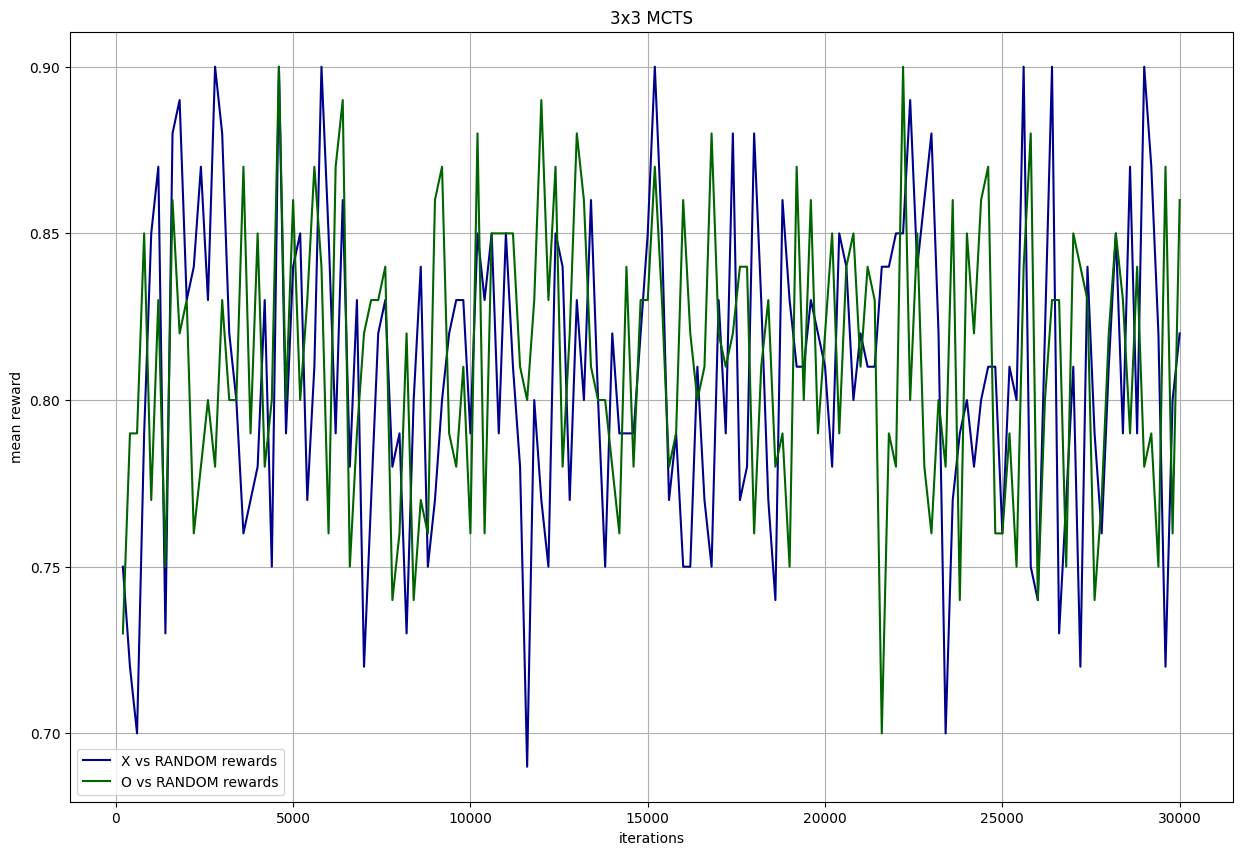

In [57]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
ax.legend()
ax.set_title(f'3x3 MCTS')
ax.grid(True)

In [58]:
%%time
env = TicTacToe(4, 4, 4)

iterations = 10000
mcts_x = MCTS(env, 0, player_1)
steps, rewards_x = mcts_x.train(iterations)

mcts_o = MCTS(env, 1, player_1)
steps, rewards_o = mcts_x.train(iterations)

100%|██████████| 10000/10000 [01:33<00:00, 106.85it/s]


10000(10000): [reward: 0.7]


100%|██████████| 10000/10000 [01:29<00:00, 111.65it/s]

10000(10000): [reward: 0.53]
CPU times: user 2min 58s, sys: 5.9 s, total: 3min 4s
Wall time: 3min 3s


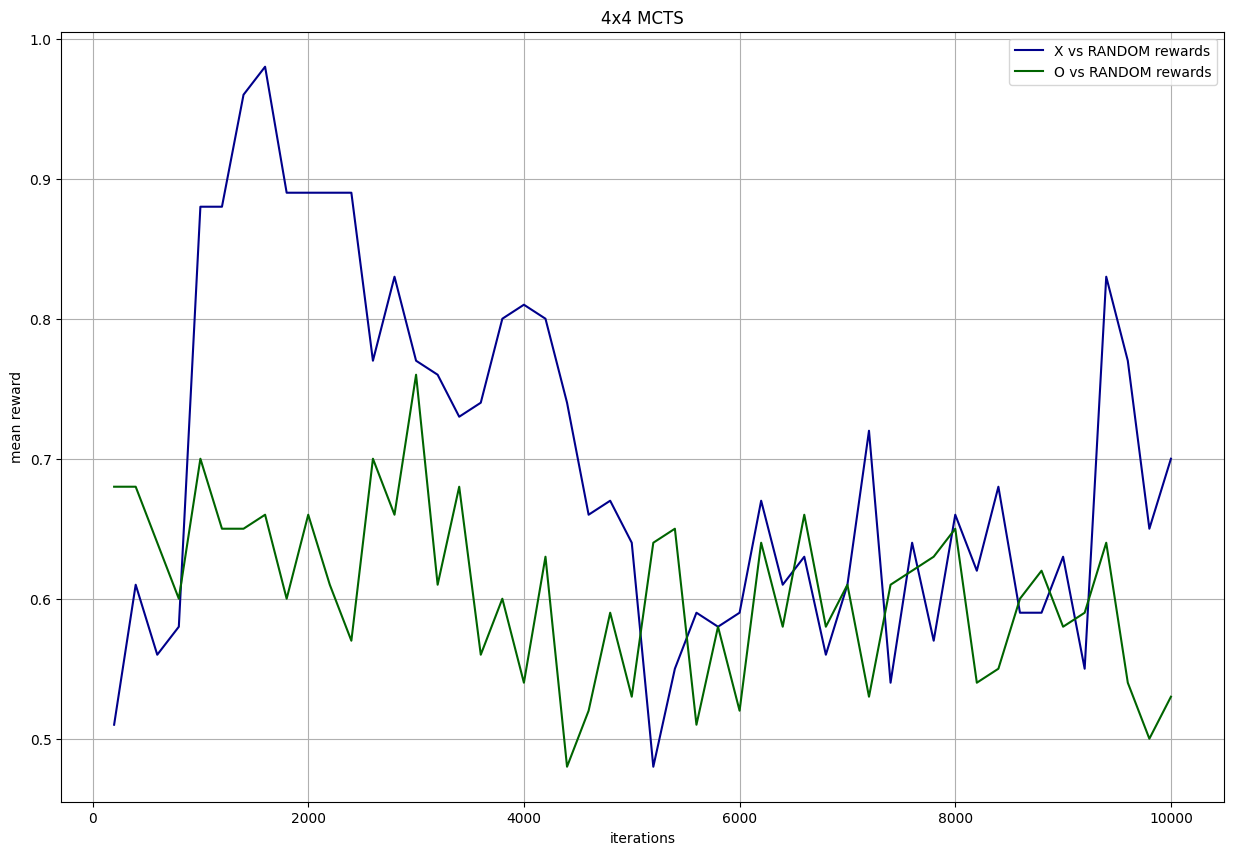

In [59]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
ax.legend()
ax.set_title(f'4x4 MCTS')
ax.grid(True)

In [60]:
%%time
env = TicTacToe(5, 5, 5)

iterations = 5000
mcts_x = MCTS(env, 0, player_1)
steps, rewards_x = mcts_x.train(iterations)

mcts_o = MCTS(env, 1, player_1)
steps, rewards_o = mcts_x.train(iterations)

100%|██████████| 5000/5000 [02:51<00:00, 29.20it/s]

CPU times: user 5min 38s, sys: 9.4 s, total: 5min 48s
Wall time: 5min 46s


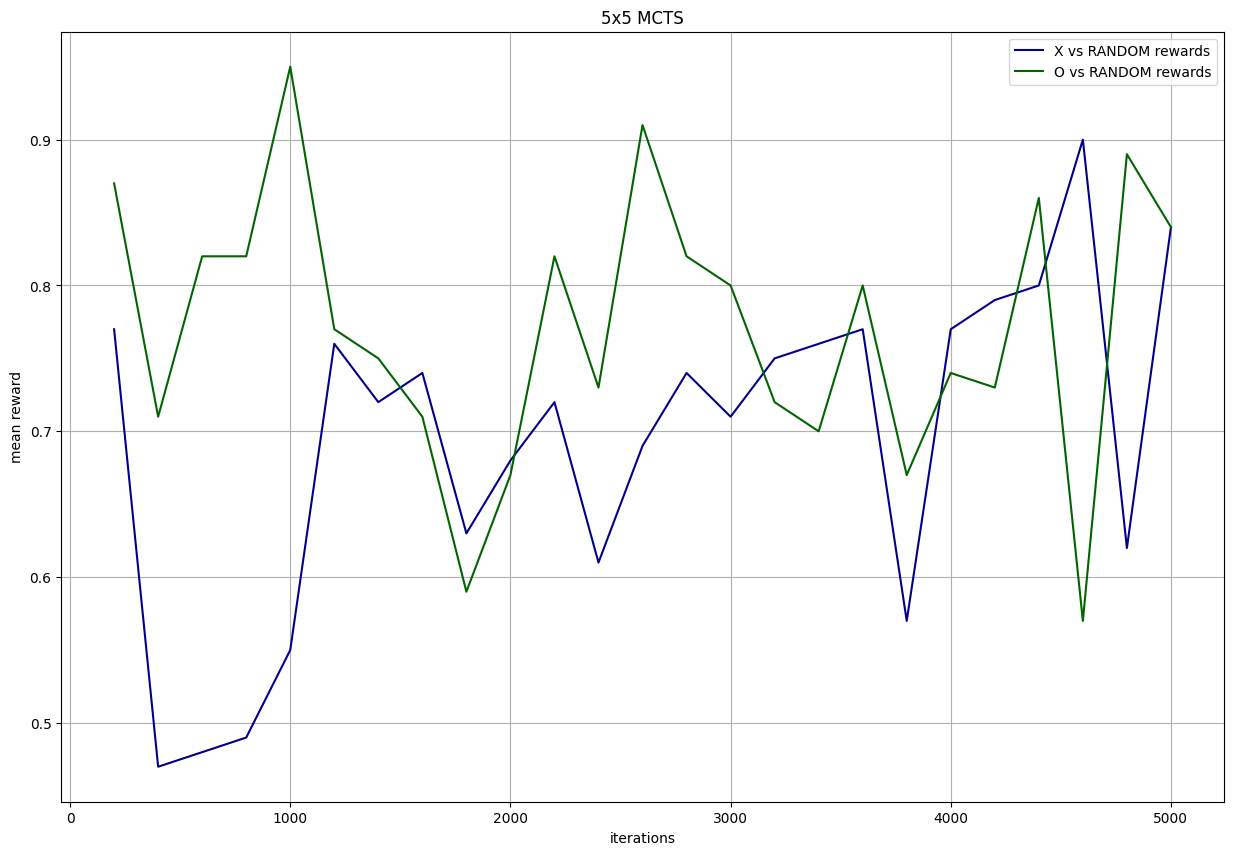

In [61]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
ax.legend()
ax.set_title(f'5x5 MCTS')
ax.grid(True)

#### Вывод:
Q-leraning показал хороший результат для крестиков, для ноликов похуже, но он положительный и устойчивый.<br>
DQN крестики обучил лучше, чем Q-leraning, а вот нолики вообще почти не обучились, хотя прослеживается положительная динамика.<br>
DDQN показал примерно такие же результаты, как и DQN, только номинально чуть-чуть повыше.<br>
Самые лучшие результаты на всех досках получились с помощью Monte Carlo tree search, но они очень неустойчивые.<br>
<br>
Скорее всего результаты получились бы повыше, если подольше обучать.<br>
Также есть предположение, что, если обучать статегии для крестиков и ноликов не друг против друга, а каждую против рандомной стратегии и проверять потом также против рандомной, то результаты будут лучше.
